In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv("preprocessed-data/krwkzt.csv")
df.head()

,Date,Close
0,2004-01-02,0.115789
1,2004-01-05,0.114777
2,2004-01-06,0.115528
3,2004-01-07,0.114479
4,2004-01-08,0.115056


In [4]:
df["Date"] = df.Date.map(lambda x: pd.to_datetime(x).date())
df = df.set_index("Date")

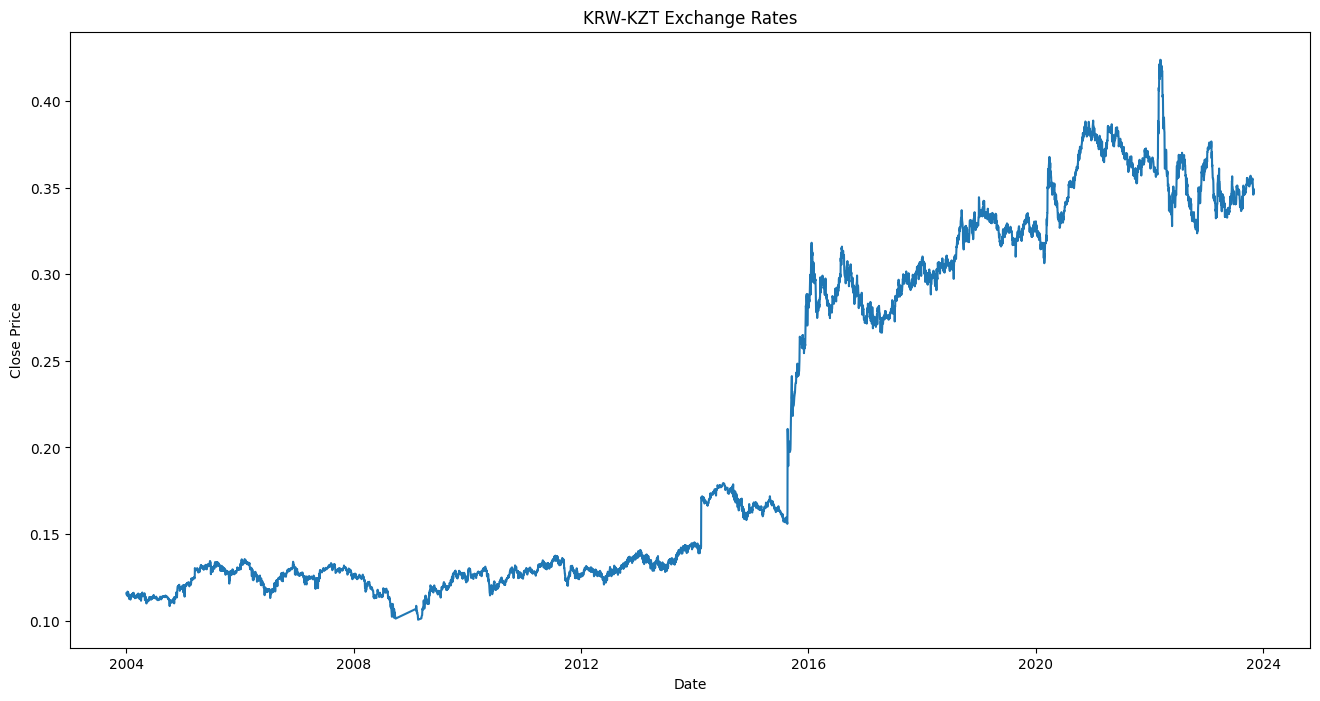

In [5]:
plt.figure(figsize=(16,8))
plt.plot(df)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("KRW-KZT Exchange Rates")
plt.savefig('./plots/krwkzt_rates')
plt.show()

In [6]:
data = df.values
data = data.astype('float32')
data

array([[0.11578887],
       [0.11477743],
       [0.11552825],
       ...,
       [0.3460535 ],
       [0.34943968],
       [0.34686083]], dtype=float32)

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
data

array([[0.04719085],
       [0.04406381],
       [0.04638508],
       ...,
       [0.7590928 ],
       [0.76956177],
       [0.7615888 ]], dtype=float32)

In [8]:
train_size = int(len(data) * 0.8)
valid_size = len(data) - train_size
train, valid = data[0:train_size,:], data[train_size:len(data),:]
train.shape, valid.shape

((4763, 1), (1191, 1))

In [9]:
def create_dataset(dataset, context_length=1, prediction_length=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-context_length-prediction_length-1):
        dataX.append(dataset[i:i+context_length])
        dataY.append(dataset[i+context_length:i+context_length+prediction_length])
    return np.array(dataX), np.array(dataY)

In [10]:
context_len, prediction_len = 96, 30
trainX, trainY = create_dataset(train, context_len, prediction_len)
validX, validY = create_dataset(valid, context_len, prediction_len)

In [11]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))

In [12]:
trainX.shape, trainY.shape

((4636, 1, 96), (4636, 30, 1))

In [13]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, context_len)))
model.add(Dense(prediction_len))
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
4636/4636 - 3s - loss: 0.0050 - 3s/epoch - 692us/step
Epoch 2/10
4636/4636 - 3s - loss: 8.5626e-04 - 3s/epoch - 586us/step
Epoch 3/10
4636/4636 - 3s - loss: 7.8729e-04 - 3s/epoch - 553us/step
Epoch 4/10
4636/4636 - 3s - loss: 7.5704e-04 - 3s/epoch - 542us/step
Epoch 5/10
4636/4636 - 2s - loss: 7.5282e-04 - 2s/epoch - 517us/step
Epoch 6/10
4636/4636 - 2s - loss: 7.3758e-04 - 2s/epoch - 463us/step
Epoch 7/10
4636/4636 - 2s - loss: 7.2754e-04 - 2s/epoch - 459us/step
Epoch 8/10
4636/4636 - 2s - loss: 7.4600e-04 - 2s/epoch - 455us/step
Epoch 9/10
4636/4636 - 2s - loss: 6.7977e-04 - 2s/epoch - 493us/step
Epoch 10/10
4636/4636 - 2s - loss: 6.8741e-04 - 2s/epoch - 454us/step


In [14]:
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)

trainY = np.reshape(trainY, (trainY.shape[0], trainY.shape[1]))
validY = np.reshape(validY, (validY.shape[0], validY.shape[1]))

trainScore = mean_squared_error(trainY[:,0], trainPredict[:,0])
print('Train Score: %.4f MSE' % (trainScore))
validScore = mean_squared_error(validY[:,0], validPredict[:,0])
print('Valid Score: %.4f MSE' % (validScore))

34/34 [==============================] - 0s 363us/step
Train Score: 0.0003 MSE
Valid Score: 0.0055 MSE


In [15]:
test_df = pd.read_csv("./krwkzt-test.csv")
test_df["Close"] = test_df.Close.map(lambda x: np.float32(x.replace(",", ".")))
test_df["Date"] = test_df.Date.map(lambda x: pd.to_datetime(x, dayfirst=True).date())
test_df = test_df.set_index("Date")
test_df.head()

,Close
Date,
2023-11-01,0.348330
2023-11-02,0.349403
2023-11-03,0.352313
2023-11-04,0.352271
2023-11-05,0.352271


In [16]:
testY = test_df.values
testY = testY.astype('float32')
testY.shape

(30, 1)

In [17]:
testX = df.values[-context_len:]
testX = testX.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
testX = scaler.fit_transform(testX)
testX = np.reshape(testX, (1, 1, testX.shape[0]))
testX.shape

(1, 1, 96)

In [18]:
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testPredict = np.reshape(testPredict, (testPredict.shape[1], testPredict.shape[0]))
testPredict.shape

1/1 [==============================] - 0s 12ms/step


(30, 1)

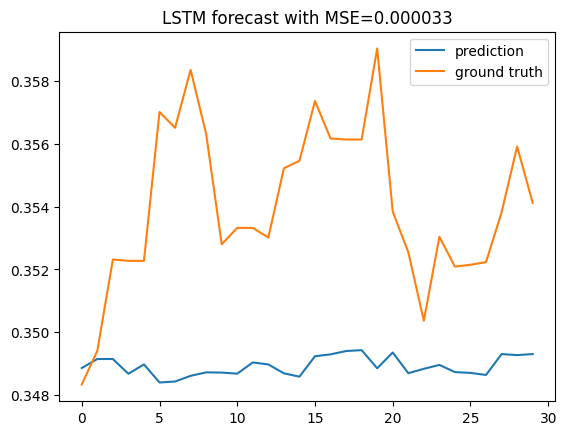

In [19]:
testScore = mean_squared_error(testY, testPredict)

plt.plot(testPredict, label='prediction')
plt.plot(testY, label='ground truth')
plt.title(f"LSTM forecast with MSE={testScore:.6f}")
plt.legend()
plt.savefig('./plots/lstm_krwkzt_test')
plt.show()